# Dispersion Analysis: Fornberg vs. DRP Stencils

This notebook compares the numerical dispersion of explicit finite-difference stencils for the second derivative obtained via several methods.

Contents:
1. **[Problem setup](#1.-Problem-Setup)**
2. **[Finite Difference Weights from Fornberg’s Algorithm](#2.-Finite-Difference-Weights-from-Fornberg’s-Algorithm)** computed via the Fornberg algorithm. [[1]](#References)
3. **[Investigation of the dispersion properties](#3.-Investigation-of-the-dispersion-properties)** of the weights.
4. **[DRP (Dispersion-Relation-Preserving) stencils (part 1)](#4.-Dispersion-Relation-Preserving-Stencils-(part-1))** following Tam and Webb [[2]](#References), Caunt [[3]](#References)
5. **[DRP stencils (part 2)](#5.-Dispersion-Relation-Preserving-Stencils-(part-2))** following Chen, Peng and Li [[4]](#References)

Both 3. and 4. above are achieved by computed by solving different constrained least-squares optimization problems.

In [1]:
import numpy as np
import scipy as sp
import sympy as sym
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from devito import Grid, Function, TimeFunction, SparseTimeFunction, Eq, Operator, solve
from functools import partial
from matplotlib import patheffects

## 1. Problem Setup
For our example we will calculate the coefficients for a 1D, 9-point stencil, 4 on each side of a centre point.

We will eventually solve the acoustic wave equation in a 1km x 1km domain.
We assume velocities lie in the range 1500m/s - 5500m/s.
We will be injecting a Ricker wavelet with peak frequency 30Hz, that is:

In [2]:
def ricker(t, f=10, A=1):
    trm = (np.pi * f * (t - 1 / f)) ** 2
    return A * (1 - 2 * trm) * np.exp(-trm)

We can do a quick Fourier transform of the Ricker wavelet, with peak frequency $30Hz$ to find the maximum frequency:

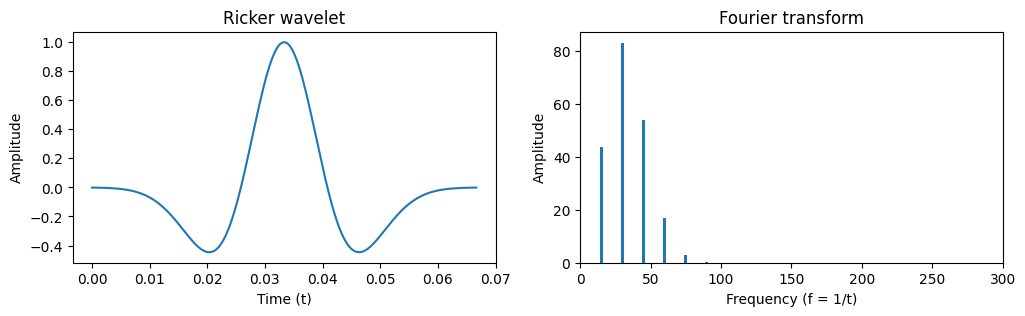

In [3]:
Nsamples = 400
f = 30
T = 2/f
t = np.linspace(0, T, Nsamples + 1)
rick = ricker(t, f=f)
rick_fft = sp.fftpack.fft(rick)
abcissa = sp.fftpack.fftfreq(Nsamples, T/Nsamples)

fig, ax = plt.subplots(1, 2)
ax[0].plot(t, rick)
ax[0].set_title('Ricker wavelet')
ax[0].set_xlabel('Time (t)')
ax[0].set_ylabel('Amplitude')

ax[1].bar(abcissa[:Nsamples//2], np.abs(rick_fft[:Nsamples//2]), width=2)
ax[1].set_xlim(0, 10*f)
ax[1].set_title('Fourier transform')
ax[1].set_xlabel('Frequency (f = 1/t)')
ax[1].set_ylabel('Amplitude')
fig.set_size_inches(12, 3)
plt.show()

The above plot demonstrates that with a peak frequency at $30Hz$ the maximum frequency of the system is $f_\text{max}\approx 100Hz$.

The Nyquist condition demands that the grid spacing $h \le v/2f_\text{max}$ that is $h_\text{max} = 7.5m$.
We pick grid spacing $h = 1000/140 \approx 7.14 < 7.5$ ie: we use a $140\times140$ 2D grid.

The Courant condition then demands that $\Delta t \le rh/v$, but $r$ (the Courant number) is dependent on the finite difference stencil coefficients.
We will start by assuming the Fornberg coefficients (section 1.) and then check the condition is still satisfied with the optimised coefficients (section 3. and section 4.).

$$
\Delta t \le \frac{h}{v_\text{max}} * \sqrt{\frac{\sum |a_\text{time}|}{d \sum |a_\text{space}|}}
$$

Where $d = 2$ is the number of spatial dimensions, $a_\text{time}$ are the stencil weights for the time discretisation and $a_\text{space}$ are the sencil weights for the spatial discretisation.

Since we use a three point (second order) time stepping method with weights 1,-2,1, we see that $\sum |a_\text{time}| = 4$.
Since we know $h$, the velocity range we expect and $v_\text{max}$ and $d$, we have that:

$$
\Delta t \le \frac{1000/140}{5500} * \sqrt{\frac{4}{2 \sum |a_\text{space}|}} \approx 0.0018366 \left( \sum |a_\text{space}| \right)^{-1/2}
$$

Peaking ahead and substituting $a_\text{space}$ for the Fornberg weights we are able to pick $\Delta t = 0.0008$.

Finally, we note that our maximum supported wave number $k_\text{max}$ is given as a function of velocity by:
$$
k_\text{max}(v) = \frac{2\pi f_\text{max}}{v}
$$

In [4]:
# Velocity parameters
vmin = 1500
vmax = 5500
vrange = np.linspace(vmin, vmax, 5)

# Frequency parameters
f = 30
fmax = 100

# Spatial parameters
extent = 1000 # 1km
npoints = 140
h = extent/npoints

# Time parameters
dt = 0.0008

def critical_dt(weights, h=1000/140, vmax=5500):
    return float(h*np.sqrt(2/np.sum([np.abs(a) for a in weights]))/vmax)

## 2. Finite Difference Weights from Fornberg’s Algorithm
This is implemented by `sympy.finite_diff_weights` and is documented on [the sympy website](https://docs.sympy.org/latest/modules/calculus/index.html#sympy.calculus.finite_diff.differentiate_finite).

If we want to take the $N^\text{th}$ derivative on a set of $2M + 1$ points $x_{-M},...,x_M$ Fornberg's algorithm will calculate weights of optimal accuracy (usually at least $N - 2M + 1$, but higher in special cases). A side effect of the algorithm is that it will calculate optimal weights for all derivatives $0^\text{th},..,N^\text{th}$ over all subsets of points $\{x_0\},\ \{x_0, x_1\},\ ...,\ \{x_{-M},...,x_M\}$ "for free".

In [5]:
# Generate a set of 2M+1 points x_i (integers ordered by distance from 0)
M = 4
x = [(1-(-1)**n*(2*n+1))//4 for n in range(2*M + 1)]
print(f'Grid points: {x}\n')

# Sympy performs Fornberg's algorithm
N = 2
weights = sym.finite_diff_weights(N, x, 0)

for ii, (derivative, th) in enumerate(zip(weights, ['ᵗʰ', 'ˢᵗ', 'ⁿᵈ'])):
    for jj, w in enumerate(derivative[ii:]):
        print(f'Optimal weights for {ii}{th} derivative on the {jj + ii + 1} point(s) x = {x[:jj + ii + 1]}:\n\t {w[:jj + ii + 1]}')
    print()

Grid points: [0, 1, -1, 2, -2, 3, -3, 4, -4]

Optimal weights for 0ᵗʰ derivative on the 1 point(s) x = [0]:
	 [1]
Optimal weights for 0ᵗʰ derivative on the 2 point(s) x = [0, 1]:
	 [1, 0]
Optimal weights for 0ᵗʰ derivative on the 3 point(s) x = [0, 1, -1]:
	 [1, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 4 point(s) x = [0, 1, -1, 2]:
	 [1, 0, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 5 point(s) x = [0, 1, -1, 2, -2]:
	 [1, 0, 0, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 6 point(s) x = [0, 1, -1, 2, -2, 3]:
	 [1, 0, 0, 0, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 7 point(s) x = [0, 1, -1, 2, -2, 3, -3]:
	 [1, 0, 0, 0, 0, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 8 point(s) x = [0, 1, -1, 2, -2, 3, -3, 4]:
	 [1, 0, 0, 0, 0, 0, 0, 0]
Optimal weights for 0ᵗʰ derivative on the 9 point(s) x = [0, 1, -1, 2, -2, 3, -3, 4, -4]:
	 [1, 0, 0, 0, 0, 0, 0, 0, 0]

Optimal weights for 1ˢᵗ derivative on the 2 point(s) x = [0, 1]:
	 [-1, 1]
Optimal weights for 1ˢᵗ derivative

That is the optimal accuracy stencil for approximating the second derivative on 9 points is:
$$
\begin{align}
\frac{\partial^2 f}{\partial x^2}
&\approx \sum_{m=-M}^M a_m f(x + mh)\\
&= - \frac{1}{560}f(x + 4h) + \frac{8}{315}f(x + 3h) - \frac{1}{5}f(x - 2h) + \frac{8}{5}f(x - h) -
\frac{205}{72} f(x) + 
\frac{8}{5}f(x + h) - \frac{1}{5}f(x + 2h) + \frac{8}{315}f(x + 3h) - \frac{1}{560}f(x + 4h)
\end{align}
$$

## 3. Investigation of the dispersion properties

Chen, Peng and Li [[4]](#References) provide the dispersion error in the form of a ratio
$$
\frac{v_\text{FD}}{v} = \delta(r_a, r, \alpha, \beta),
$$
where $v_\text{FD}$ is the velocity as calculated by the finite difference scheme, $v$ is the "true" velocity, $r_a$ is the Courant number for which we optimise our stencil (calculate the coefficients $a_m$), $r$ is the Courant number corresponding to $v$, $\alpha$ is the propagation angle, and $\beta = kh$, $k$ being the wave number and $h$ being the grid spacing. The dispersion ratio is given as:
$$
\delta(r_a, r, \alpha, \beta) 
= \frac{1}{r\beta}\arccos\left(1 + r^2\left[
    \sum_{m=1}^M a_m(
        \cos(m\beta\cos(\alpha))
        + \cos(m\beta\cos(\alpha))
        - 2
    )\right]
\right)
$$
We can also rewrite this in terms of the fundamental symbols, rather than the derived symbols as:
$$
\delta(a_m, h, \Delta t, v, k, \alpha)
= \frac{1}{k \Delta t}\arccos\left(1 + \frac{v^2\Delta t^2}{h^2}\left[
    \sum_{m=1}^M a_m(
        \cos(mkh\cos(\alpha))
        + \cos(mkh\cos(\alpha))
        - 2
    )\right]
\right)
$$

In [6]:
def dispersion_ratio(weights, h, dt, v, k, alpha):
    if k == 0:
        ratio = 1
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        ratio = np.acos(1 + ((v**2)*(dt**2)/(h**2))*total)/(v*k*dt)
    return ratio

Note that the phase velocity error ratio only uses the unique weights and assumes a symmetric stencil. For the weights calculated using Fornberg's algorithm these are:

In [7]:
fornberg = np.array(weights[-1][-1][::2], dtype=np.float64)
print(fornberg)

[-2.84722222e+00  1.60000000e+00 -2.00000000e-01  2.53968254e-02
 -1.78571429e-03]


We can plot the phase velocity error ratio for the full range of dispersion angles $\alpha$ and a range of $\beta = kh$, as well as different Courant numbers $r = v\Delta t/h$. We will do this multiple times, so we create a plotting function.

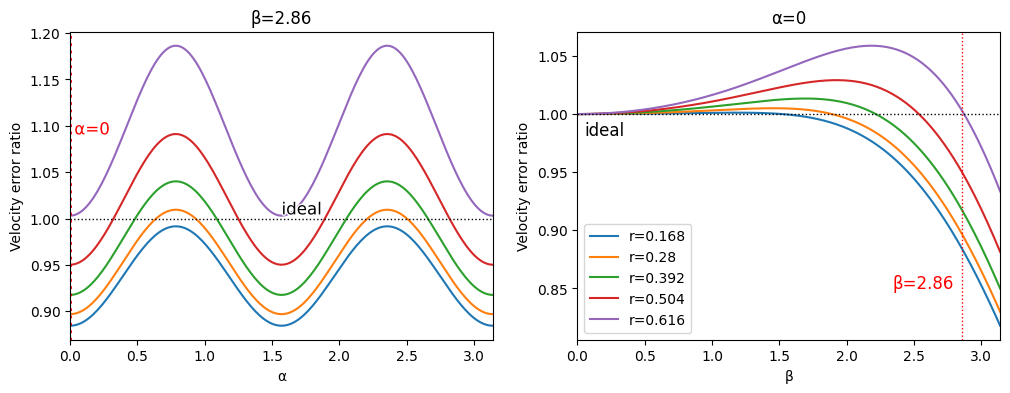

In [8]:
def dispersion_plot(weights, h, dt, velocity, k=0.4, alpha=0, ax=None):
    assert ax is not None and len(ax) == 2
    linspace = np.linspace(0, np.pi, 200)

    beta = k*h
    courant = [v*dt/h for v in velocity]
    
    # Fix beta, vary alpha
    for r, v in zip(courant, velocity):
        data = np.array([dispersion_ratio(weights, h, dt, v, k, a) for a in linspace])
        ax[0].plot(linspace, data, label=f'{r=:.3g}')
    ax[0].plot(linspace, np.ones_like(linspace), 'k:', lw=1)
    ax[0].annotate('ideal',
        xy=(np.pi/2, 1), xycoords='data',
        xytext=(0, 3), textcoords='offset points', fontsize=12,
        path_effects=[patheffects.withStroke(linewidth=2, foreground="w")]
    )
    ax[0].axvline(alpha, c='red', ls=':', lw=2)
    ylim = ax[0].get_ylim()
    ax[0].annotate(f'α={alpha:.3g}',
        xy=(alpha, ylim[0] + (ylim[1] - ylim[0])*2/3), xycoords='data',
        xytext=(3, 0), textcoords='offset points', fontsize=12, color='red',
        path_effects=[patheffects.withStroke(linewidth=2, foreground="w")]
    )
    ax[0].set_title(f'β={beta:.3g}')
    ax[0].set_xlabel('α')
    ax[0].set_xlim([0, np.pi])
    ax[0].set_ylabel('Velocity error ratio')

    # Fix alpha, vary beta
    for r, v in zip(courant, velocity):
        data = np.array([dispersion_ratio(weights, h, dt, v, b/h, alpha) for b in linspace])
        ax[1].plot(linspace, data, label=f'{r=:.3g}')
    ax[1].plot(linspace, np.ones_like(linspace), 'k:', lw=1)
    ax[1].annotate('ideal',
        xy=(0, 1), xycoords='data',
        xytext=(5, -15), textcoords='offset points', fontsize=12
    )
    ax[1].axvline(beta, c='red', ls=':', lw=1)
    ylim = ax[1].get_ylim()
    ax[1].annotate(f'β={beta:.3g}',
        xy=(beta, ylim[0] + (ylim[1] - ylim[0])/6), xycoords='data',
        xytext=(-50, 0), textcoords='offset points', fontsize=12, color='red'
    )
    ax[1].set_title(f'α={alpha:.3g}')
    ax[1].set_xlabel('β')
    ax[1].set_xlim([0, np.pi])
    ax[1].set_ylabel('Velocity error ratio')
    ax[1].legend()

    return ax

fig, ax = plt.subplots(1, 2)
dispersion_plot(fornberg, h, dt, velocity=vrange, ax=ax)
fig.set_size_inches(12,4)
plt.show()

Notice that for small $\beta$, so either smaller grid spacing $h$ or smaller wave number $k$ (equivalently smaller velocities $v$) the velocity error ratio is close to the ideal value of 1. As $\beta$ becomes larger, the error increases and the error is sinuoidal in the propagation angle $\alpha$, with the worst missfit being obtained exactly when the wave is propagating aligned to the grid directions.

## 3.1. Observing the effects on wavefields
We now use Devito to solve the acoustic wave equation, propagating a Ricker wavelet source from the centre. We define a function that solves the acoustic wave equation in a 2D grid with reflecting boundary conditions. Receivers are also placed near the top of the domain allowing us to later generate a shot profile. The source in the centre of the 1km by 1km domain is simulated for at total of 0.6 seconds, long enough for the wave to pass the receivers and be reflected by the boundary

Note the use of the weights keyword argument passed to the derivative, `u.dx2(weights=weights)`, allowing the use of custom stencil weights.

In [9]:
def acoustic(weights, h, dt, v, f=f, extent=extent):
    # Spatial Domain
    origin = (0., 0.)
    grid_extent = (extent, extent)
    sn = int(np.ceil((grid_extent[0] - origin[0])/h))
    shape = (sn, sn)

    # Time Domain
    t0 = 0
    t1 = 0.6
    tn = int(np.ceil((t1 - t0)/dt))

    # Courant number
    r = v*dt/h

    # Devito expects all coefficients from -M to M
    weights = np.concatenate([weights[::-1], weights[1:]])
    space_order = len(weights) - 1

    # Source coordinates
    sx = grid_extent[0]/2 - origin[0]
    sy = grid_extent[1]/2 - origin[1]

    # Construct 2D Grid
    grid = Grid(shape=shape, extent=grid_extent)
    x, y = grid.dimensions

    # Background velocity
    velocity = Function(name="velocity", grid=grid, space_order=space_order)
    velocity.data[:] = v

    # Source
    t = np.linspace(t0, t1, tn)
    source = SparseTimeFunction(
        name="ricker",
        npoint=1,
        coordinates=[(sx, sy)],
        nt=tn,
        grid=grid,
        time_order=2,
        space_order=space_order
    )
    source.data[:, 0] = ricker(t, f=f)

    # Receiver coordinates
    nrecv = 101
    rx = np.linspace(origin[0], grid_extent[0], nrecv)
    ry = 0.02*grid_extent[1]*np.ones(nrecv)
    receiver = SparseTimeFunction(
        name="recv",
        npoint=nrecv,
        coordinates=np.array([rx, ry]).T,
        nt=tn,
        grid=grid
    )

    # Wave field
    u = TimeFunction(name="u", grid=grid, time_order=2, space_order=space_order)

    # Acoustic wave equation
    pde = (1/velocity**2)*u.dt2 - u.dx2(weights=weights) - u.dy2(weights=weights)
    stencil = Eq(u.forward, solve(pde, u.forward))

    # Inject source, create and run operator
    src_term = source.inject(field=u.forward, expr=source*velocity*velocity*dt*dt)
    recv_term = receiver.interpolate(expr=u.forward)
    op = Operator([stencil] + src_term + recv_term, subs=grid.spacing_map)
    op(time=tn - 1, dt=dt)

    return u.data[-1], receiver.data, r

Before running the propagator, we check the critical timestep size for the Fornberg stencil weights, these are the default weights used by Devito, but specifying them does not harm.

In [10]:
critical_dt(fornberg)

0.0008494955628995738

Note that our chosen $\Delta t = 0.0008$ is less than the critical timestep, we simulate the wave propagation using this timestep, but also at half the timestep, which corresponds to a Courtant number less than critical and double the timestep, which is unstable.

In [11]:
u , data , r = acoustic(weights=fornberg, h=h, dt=dt, v=1500)
um, datam, rm = acoustic(weights=fornberg, h=h, dt=dt/2, v=1500)
up, datap, rp = acoustic(weights=fornberg, h=h, dt=2*dt, v=1500)

Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


We are going to plot lots of wave fields and shot profiles, so we set up the following plotting functions to do this:

In [12]:
def plot_wave(u, ax, clip=0.5, extents=(0, 1000, 0, 1000), hline=None, r=None):
    ax.imshow(
        u.T,
        extent=extents,
        cmap='seismic',
        vmin=-clip,
        vmax=clip
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if r:
        ax.set_title(f'{r = :.3g}')
    if hline:
        assert len(hline) == 4
        ax.plot(
            (hline[0], hline[2]),
            (hline[1], hline[3]),
            'g--', lw=2
        )

def plot_shot(data, ax, clip=0.1, extents=(0, 1000, 0, 0.6), vline=None, r=None, first_arrival=True):
    ax.imshow(
        data[::-1,:],
        extent=extents,
        vmin=-clip,
        vmax=clip,
        cmap='grey',
        aspect=(extents[1] - extents[0])/(extents[3] - extents[2]),
    )
    ax.invert_yaxis()
    ax.set_xlabel('x')
    ax.set_ylabel('t')

    arrival = None
    if isinstance(first_arrival, np.ndarray) or first_arrival:
        time = np.linspace(extents[2], extents[3], data.shape[0])
        space = np.linspace(extents[0], extents[1], data.shape[1])
        if not isinstance(first_arrival, np.ndarray):
            arrival = time[np.argmax(np.abs(data)>0.01, axis=0)]
            ax.plot(space, arrival, c='red', lw=1)
            ax.annotate(f'first arrival',
                xy=((extents[1] - extents[0])/2, arrival[arrival.size//2]), xycoords='data',
                xytext=(5, 5), textcoords='offset points', fontsize=12, color='red',
                path_effects=[patheffects.withStroke(linewidth=2, foreground="k")]
            )
        else:
            ax.plot(space, first_arrival, c='red', lw=1)
    if r:
        ax.set_title(f'{r = :.3g}')
    if vline:
        assert len(vline) == 4
        ax.plot(
            (vline[0], vline[2]),
            (vline[1], vline[3]),
            'g--', lw=2
        )
    return arrival

def plot_profile(array, ax, clip=1, extent=(0, 1), axis_labels=('x', 'A'), first_arrival=None):
    ax.plot(np.linspace(extent[0], extent[1], array.size), array)
    ax.set_xlim(extent)
    ax.set_ylim((-clip, clip))
    ax.set_aspect((extent[1] - extent[0])/(2*clip))
    if first_arrival is not None:
        ax.axvline(first_arrival, c='red', ls='--', lw=1)
        ax.annotate(f'first arrival',
            xy=(first_arrival, 0), xycoords='data',
            xytext=(-70, 5), textcoords='offset points', fontsize=12, color='red'
        )
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])

First look at the wave field plotted over the whole domain, with the reflected wavelet plotted below the corresponding wavefiled along the greeen dasahed line indicated. The plots from left to right go from the smallest Courtant number to largest, the first being sub-critical, the second, _just_ sub-critical and the third unstable.

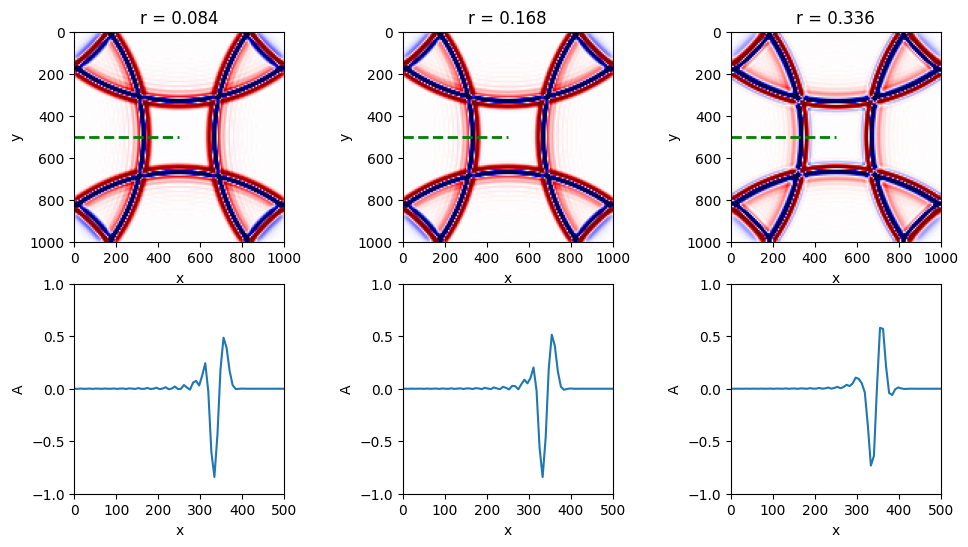

In [13]:
fig, ax = plt.subplots(2, 3)
plot_wave(um, ax[0, 0], hline=(0, 500, 500, 500), r=rm)
plot_wave( u, ax[0, 1], hline=(0, 500, 500, 500), r=r)
plot_wave(up, ax[0, 2], hline=(0, 500, 500, 500), r=rp)

shape = u.shape
plot_profile(um[shape[0]//2, :shape[1]//2], ax[1,0], extent=(0, 500))
plot_profile( u[shape[0]//2, :shape[1]//2], ax[1,1], extent=(0, 500))
plot_profile(up[shape[0]//2, :shape[1]//2], ax[1,2], extent=(0, 500))

fig.set_size_inches(12, 6)
plt.show()

Notice that all three cases show dispersion. This can be seen as the ripples trailing behind the reflected wave in the wave field plot and the small oscillations in the wavelet plot. A combination of the "seismic" colour map and aggressively clipping the the function makes this very obvious.

Note that in the unstable case there is a wavefront that is somehow ahead of the original wavelet! The large peak of the wavelet is also growing in amplitude and as a result the solution is not physically accurate. In the unstable case the first arrival time is also affected, and this becomes very obvious when looking at shot profiles.

Again the plots from left to right go from the smallest Courant number to largest. The correspinging wavelet is plotted along the green dashed line and the **true** first arrival time is clearly marked on all of the plots.

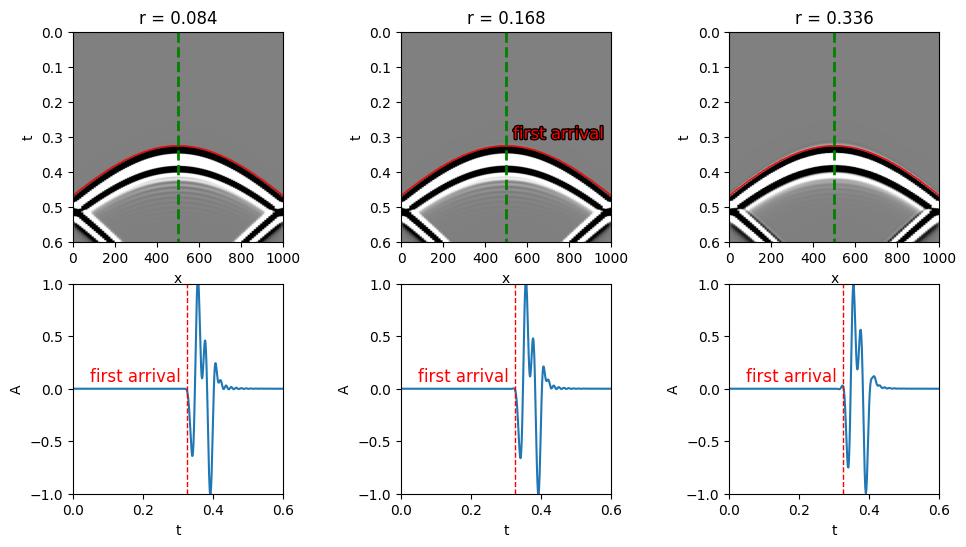

In [14]:
fig, ax = plt.subplots(2, 3)

arrival = plot_shot(data,  ax[0, 1], vline=(500, 0, 500, 0.6), r=r)
plot_shot(datam, ax[0, 0], vline=(500, 0, 500, 0.6), r=rm, first_arrival=arrival)
plot_shot(datap, ax[0, 2], vline=(500, 0, 500, 0.6), r=rp, first_arrival=arrival)

width = data.shape[1]
plot_profile(datam[:, width//2], ax[1, 0], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile( data[:, width//2], ax[1, 1], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile(datap[:, width//2], ax[1, 2], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])

fig.set_size_inches(12, 6)
plt.show()

The dispersion is evident at all three Courant numbers as ripples appearing behind the initial wavelet.

In the unstable case it is also clear that the first arrival time for the wavelet is early and the artificial and spurious peak arrives ahead of the true trough of the Ricker wavelet.

We will repeat this analysis for 2 different dispersions minimising stencils.

## 4. Dispersion Relation Preserving Stencils (part 1)
To reduce the dispersion we will solve a minimisation problem to find the weights for the finite difference stencil.

We start by making the simplifying assumption that our stencil should be symmetric, that is $a_{-m} = a_m$. By inspecting coefficients of the Taylor expansion of the general stencil for $\frac{\partial^2 u}{\partial x^2}$ we obtain the following standard constraints for the coefficients:
$$
a_0 + \sum_{m=1}^M 2a_m = 0
$$
$$
\sum_{m=1}^M a_m m^2 = 1
$$
$$
\frac{2}{(2n)!}\sum_{m=0}^M a_m m^{2n} = 0 \qquad \text{ for } n=2,...,\lfloor M/2 \rfloor
$$

Notice that for any $M$ this system of constraints is under-determined and therefore does not have a unique solution. We will choose some objective function to minimise as a way to close the system.

The minimisation algorithm will start by using an initial guess that is the result of performing the Fornberg algorithm.

We can encode the constraints for `scipy` as follows:

In [15]:
initial_guess = fornberg

constraints = [{
    'type': 'eq',
    'fun': lambda x: x[0] + 2*np.sum(x[1:])
}]
constraints += [{
    'type': 'eq',
    'fun': lambda x: np.sum([xi*m**2 for m, xi in enumerate(x)]) - 1
}]
constraints += [{
    'type': 'eq',
    'fun': lambda x: np.sum([xi*m**(2*jj) for m, xi in enumerate(x)])
} for jj in range(2, (len(initial_guess) + 1)//2)]

We are now free to choose an objective function for the stencil weights to optimise over. We follow the method of Tam and Webb [2](#References) and executed in the Masters thesis of Caunt [3](#References) (for second derivatives) and minimise the $L^2$ norm of the difference between the derivative and the stencil in Fourier space. We minimise $\Phi(a_m)$, where
$$
\Phi(a_m):= \int_{\pi/2}^{\pi/2} \left| \varphi^2 + \sum_{m=-M}^M a_m e^{im\varphi} \right|^2 d\varphi,
$$
which can be be written in terms of cosines as:
$$
\Phi(a_m) = 2\int_{0}^{\pi/2} \left| \varphi^2 + 2\sum_{m=-M}^M a_m\cos(m\varphi) \right|^2 d\varphi.
$$
We use the trapesium rule to approximate this integral and using Sequential Least Squares Programming (SLSQP) to perform a constrained minimisation of this cost function.

In [16]:
def objective(a):
    x = np.linspace(0, np.pi/2, 201)
    m = np.arange(1, len(a) + 1)
    y = x**2 + a[0] + 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(a[1:], m)], axis=0)
    return sp.integrate.trapezoid(y**2, x=x)

print(f'Value of objective function at initial guess: {objective(initial_guess)}')
opt1 = sp.optimize.minimize(objective, initial_guess, method='SLSQP', constraints=constraints, options=dict(ftol=1e-15, maxiter=500))
print(opt1)

Value of objective function at initial guess: 2.2836089441941713e-05
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 4.4094726504681656e-08
       x: [-2.942e+00  1.677e+00 -2.412e-01  3.839e-02 -3.621e-03]
     nit: 11
     jac: [ 1.521e-04  2.189e-04 -1.827e-06 -2.522e-04 -3.561e-04]
    nfev: 66
    njev: 11


We first check that our choice of $\Delta t$ is still stable for this choice of coefficients, which we will refer to as DRP stencil 1.

In [17]:
drp_stencil1 = opt1.x
critical_dt(drp_stencil1)

0.000829494129842826

It is. We continue by comparing how closely the Fornberg stencil weights (the initial guess) approximate the objective function and compare this to the result of the optimisation algorithm.

The left plot shows how closely the function of the weights in each case approximate $\varphi^2$, which is the term corresponding to the second drivative in Fourier space and the term that we are trying to approximate. The right plot is the logarithm of the difference between the functions, to better distinguish the difference.

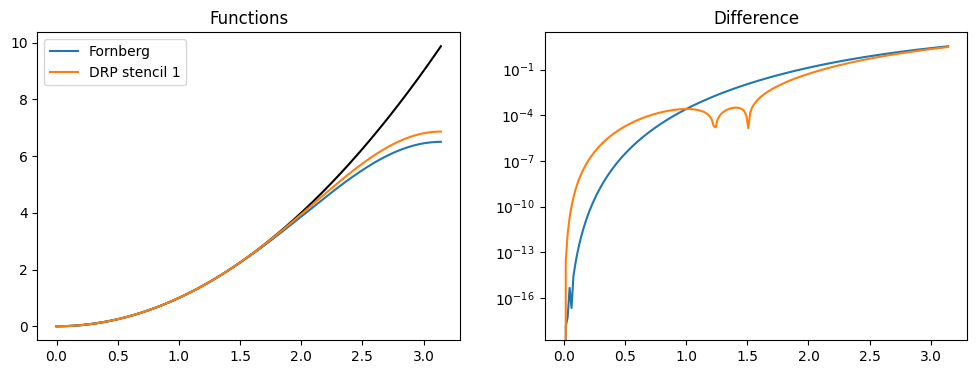

In [18]:
x = np.linspace(0, np.pi, 201)
m = np.arange(1, len(fornberg) + 1)
y_fornberg = - fornberg[0] - 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(fornberg[1:], m)], axis=0)
y_drp1 = - drp_stencil1[0] - 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(drp_stencil1[1:], m)], axis=0)

fig, ax = plt.subplots(1, 2)
ax[0].plot(x, x**2, 'k')
ax[0].plot(x, y_fornberg, label='Fornberg')
ax[0].plot(x, y_drp1, label='DRP stencil 1')
ax[0].legend()
ax[0].set_title('Functions')

ax[1].semilogy(x, np.abs(x**2 - y_fornberg))
ax[1].semilogy(x, np.abs(x**2 - y_drp1))
ax[1].set_title('Difference')

fig.set_size_inches(12, 4)
plt.show()

Both sets of weight approximate the curve well, but it is clear from the right hand plot that the error is smaller for DRP stencil 1 over a larger range; less than $10^-4$ in the whole range $[0, \pi/2]$.

We can also look at the velocity error ratio for this set of coefficients, as outlined by Chen, Peng and Li [4](#References) and we did above for the Fornberg weights.

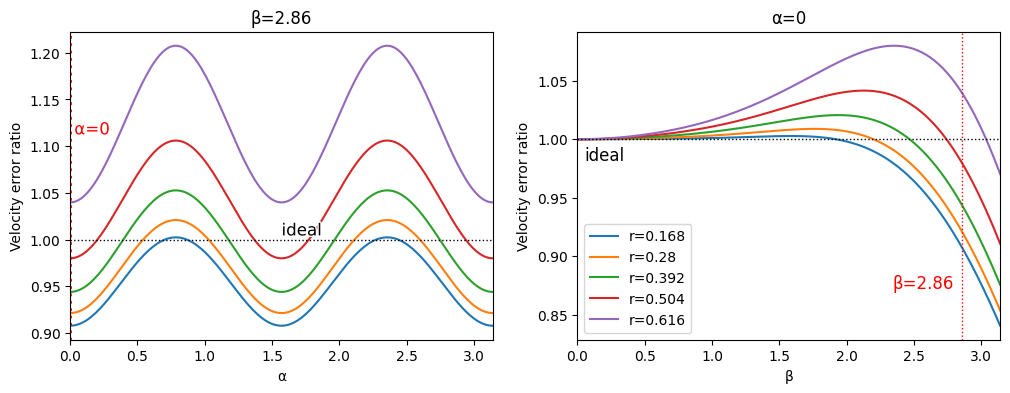

In [19]:
fig, ax = plt.subplots(1, 2)
dispersion_plot(drp_stencil1, h, dt, velocity=vrange, ax=ax)
fig.set_size_inches(12,4)
plt.show()

Errr.... this looks worse :/

In [20]:
u , data , r = acoustic(weights=drp_stencil1, h=h, dt=dt, v=1500)
um, datam, rm = acoustic(weights=drp_stencil1, h=h, dt=dt/2, v=1500)
up, datap, rp = acoustic(weights=drp_stencil1, h=h, dt=2*dt, v=1500)

Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


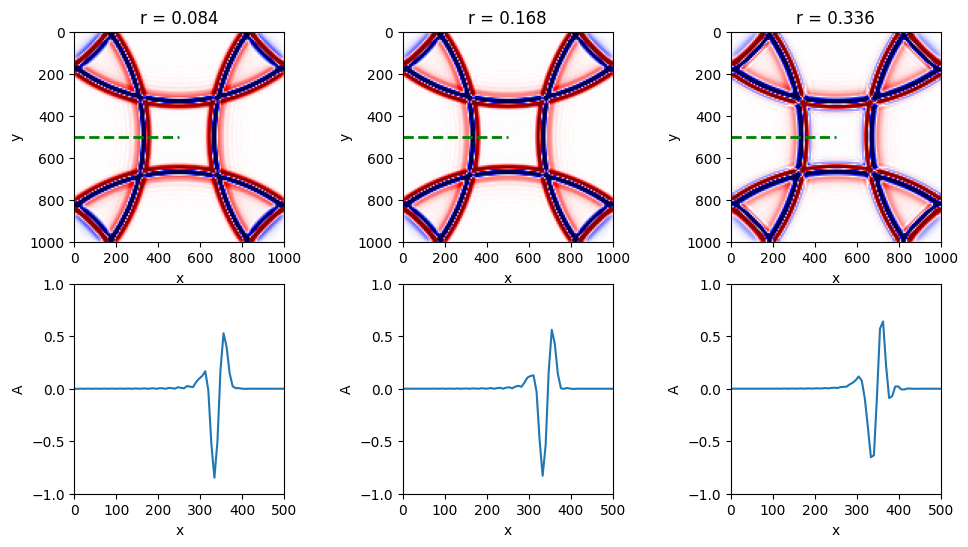

In [21]:
fig, ax = plt.subplots(2, 3)
plot_wave(um, ax[0, 0], hline=(0, 500, 500, 500), r=rm)
plot_wave( u, ax[0, 1], hline=(0, 500, 500, 500), r=r)
plot_wave(up, ax[0, 2], hline=(0, 500, 500, 500), r=rp)

shape = u.shape
plot_profile(um[shape[0]//2, :shape[1]//2], ax[1,0], extent=(0, 500))
plot_profile( u[shape[0]//2, :shape[1]//2], ax[1,1], extent=(0, 500))
plot_profile(up[shape[0]//2, :shape[1]//2], ax[1,2], extent=(0, 500))

fig.set_size_inches(12, 6)
plt.show()

But the ripples are smaller at least!

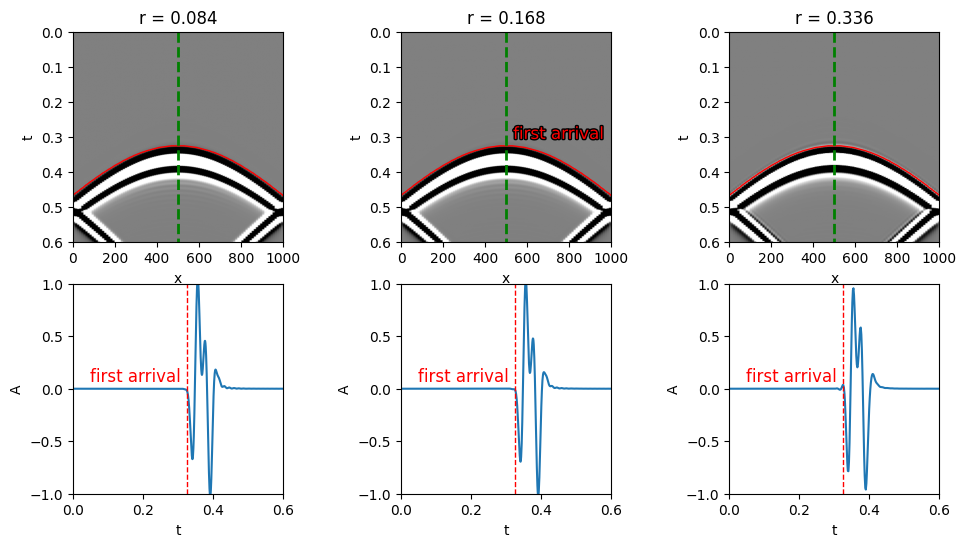

In [22]:
fig, ax = plt.subplots(2, 3)

arrival = plot_shot(data,  ax[0, 1], vline=(500, 0, 500, 0.6), r=r)
plot_shot(datam, ax[0, 0], vline=(500, 0, 500, 0.6), r=rm, first_arrival=arrival)
plot_shot(datap, ax[0, 2], vline=(500, 0, 500, 0.6), r=rp, first_arrival=arrival)

width = data.shape[1]
plot_profile(datam[:, width//2], ax[1, 0], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile( data[:, width//2], ax[1, 1], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile(datap[:, width//2], ax[1, 2], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])

fig.set_size_inches(12, 6)
plt.show()

## 5. Dispersion Relation Preserving Stencils (part 2)
Chen, Peng and Li try to minimise another objective function $\xi$ which is defined in terms of the $\delta$ defined above. Specifically they minimise
$$
\xi(h, \Delta t, v_\text{min}, v_\text{max}) :=
| \delta(r_a, r_\text{min}, \alpha, \beta_\text{max}(v_\text{min})) - 1 | +
| \delta(r_a, r_\text{max}, \alpha, \beta_\text{max}(v_\text{max})) - 1 |,
$$
For a choice of fixed parameters. This is a valid tactic, but only the objective $\xi$ only minimises the velocity error ratio at a finite number of very specific points.

Here we make a few observations and define our own objective function for minimising dispersion. Note well that this is the "special sauce" behind all custom stencils. Chosing some objective function that minimises some measurable quantity of interest, in this case dispersion.

The first observation is that $\delta(\cdot) = v_\text{FD}/v$ is in fact a ratio and the quantity $| \delta(\cdot) - 1 |$ is equivalent up to a factor to $| v_\text{FD} - v |$. We define the velocity error difference $\hat{\delta} := | v_\text{FD} - v |$.

In [23]:
def dispersion_difference(weights, h, dt, v, k, alpha):
    if k == 0:
        diff = 0
    else:
        m = len(weights)
        cosines = np.array([
            np.cos(m*k*h*np.cos(alpha)) + np.cos(m*k*h*np.sin(alpha)) - 2
            for m in range(1, m)
        ])
        total = np.sum(np.array(weights)[1:]*cosines)
        theta = 1 + (v**2)*(dt**2)*total/(h**2)
        diff = np.abs(np.acos(theta)/(k*dt) - v)
    return diff

We can think of the dispersion plots that we have seen so far as cross sections of level sets of a function of 3 dimensions. For a fixed set of weights $a_m$, a grid pacing $h$ and timestep $\Delta t$, $\hat{\delta}$ is a function of velocity $v$, whave number $k$ and propagation angle $\alpha$. We can now plot the isosurfaces of this function, corresponding to different velocites:

In [24]:
def plot_levelset(weights, alpha, k, velocity, ax, h, dt):
    assert len(ax.flatten()) >= len(velocity)
    delta_wrapper = partial(dispersion_difference, weights=weights, h=h, dt=dt)

    level_sets = []
    courant = []
    for v in velocity:
        courant.append(v*dt/h)
        diff = np.array([[delta_wrapper(alpha=a, k=k_, v=v) for k_ in k] for a in alpha])
        level_sets.append(np.log(1 + diff))
        norm = colors.Normalize(
            min([np.nanmin(z) for z in level_sets]),
            max([np.nanmax(z) for z in level_sets]),
        )

    beta = k*h
    xs, ys = np.meshgrid(beta, alpha)
    for ii, (axis, zs) in enumerate(zip(ax.flatten(), level_sets)):
        r = courant[ii]
        cb = axis.pcolormesh(xs, ys, zs, norm=norm)
        axis.set_title(f'{r = :.3g}')
        axis.set_xlabel('β')
        axis.set_ylabel('α')
        axis.set_facecolor('r')

    return cb

To emphasise the small differences at lower Courant numbers, $\log(1 + \hat{\delta})$ is plotted. The weights used for this visualisation are the Fornberg weights:

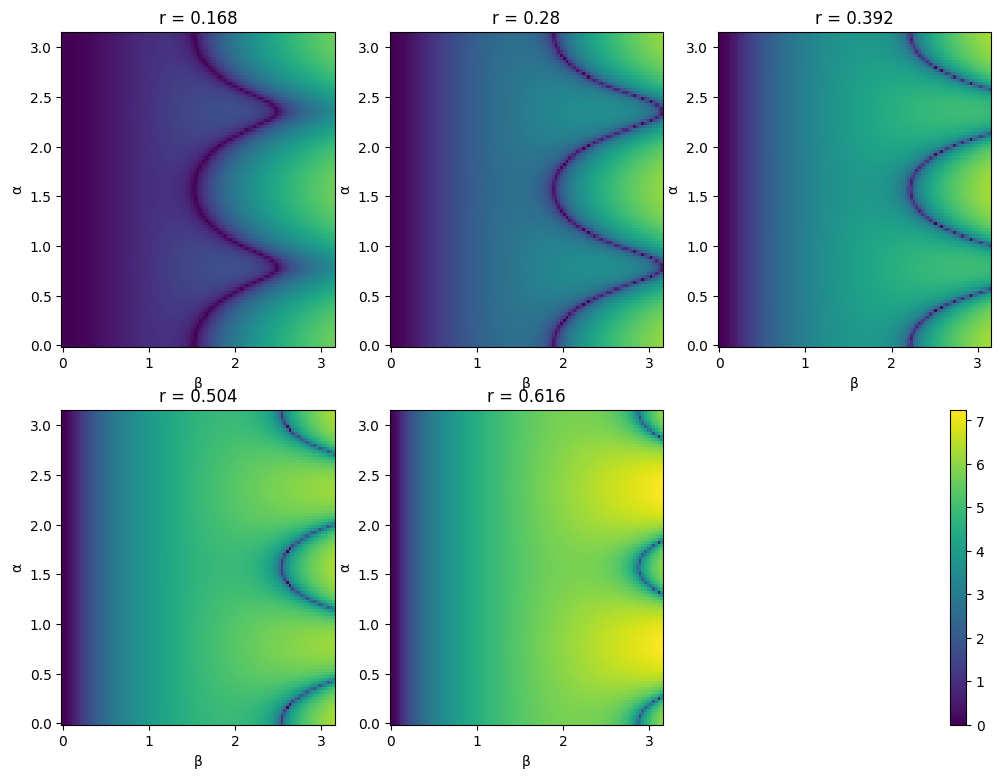

In [25]:
resolution = 101
alpha = np.linspace(0, np.pi, resolution)
k = np.linspace(0, np.pi/h, resolution)

fig, ax = plt.subplots(2, 3)
cb = plot_levelset(fornberg, alpha, k, vrange, ax, h, dt)
ax[-1][-1].set_visible(False)
fig.colorbar(cb, ax=ax[-1][-1])
fig.set_size_inches(12, 9)
plt.show()

The above isosurfaces behave similarly to the velocity error ratio plots; a cross secion along the right hand edge (constant $\beta$) oscillates like the periodic left hand velocity error ratio plots, a cross section along the bottom edge (constant $\alpha$) is slowly increasing and then decreasing, before growing larger. Recall that the colour scale logarthmic.

We can think about trying to minimise the dispersion for a whole range of $\alpha$, $k$ and $v$, which we can by minimising the following functional, which integrates $\hat{\delta}$ over a pre-determined region for a fixed $h$ and $\Delta t$:
$$
\hat{\Phi}(a_m) = 
\int_{v_\text{min}}^{v_\text{max}}
    \int_0^{k_\text{max}(v)}
        \int_0^{\pi/4}
            \hat{\delta}(a_m, h, \Delta t, v, k, \alpha)
        \ d\alpha
    dk
dv
$$
Where we integrate v from $v_\text{min}$ to $v_\text{max}$, which are the minimum and maximum velocities that we want to model, $k$ is integrated from $0$ to $k_\max(v):= 2\pi f_\text{max}/v$ - the maximum supported wave number for a given velocity, and $\alpha$ is integrated from $0$ to $\pi/4$ which is a half period (and thus encapsulates the full range of variability of $\alpha$).

`scipy` contains a general adaptive quadrature scheme, but given that this three dimensional integral must be evaluated at every step of the minimisation algorithm, we use the trapesium rule on a fairly coarse discretisation.

In [26]:
def objective2(a, h, dt, fmax=100, vmin=1500, vmax=5500, alphamin=0, alphamax=np.pi/4, res=31):
    diff_wrapper = partial(dispersion_difference, weights=a, h=h, dt=dt)

    k_integral = np.zeros(res)
    v_space = np.linspace(vmin, vmax, res)
    alpha_space = np.linspace(alphamin, alphamax, res)
    for ii, v in enumerate(v_space):
        alpha_integral = np.zeros(res)
        k_space = np.linspace(0, 2*np.pi*fmax/v, res)
        for jj, k in enumerate(k_space):
            alpha_data = np.array([
                diff_wrapper(alpha=alpha, k=k, v=v) for alpha in alpha_space
            ])
            alpha_integral[jj] = np.trapezoid(alpha_data, alpha_space)
        k_integral[ii] = np.trapezoid(alpha_integral, k_space)
    v_integral = np.trapezoid(k_integral, v_space)

    return v_integral

We again use Sequential Least Squares Programming (SLSQP) to perform a constrained minimisation of this cost function, with the same constraints on $a_m$. Notice that we must pick a $h$ and $\Delta t$ to optimise for.

Warning: Depending on your computer's hardware, this cell may take a long time to run!

In [27]:
objective2_wrapper = partial(objective2, h=h, dt=dt)
print(f'Value of objective function at initial guess: {objective2_wrapper(initial_guess)}')
opt2 = sp.optimize.minimize(objective2_wrapper, initial_guess, constraints=constraints, method='SLSQP')
print(opt2)

Value of objective function at initial guess: 7160.542407791252


/tmp/ipykernel_314736/237837473.py:12: RuntimeWarning: invalid value encountered in arccos
  diff = np.abs(np.acos(theta)/(k*dt) - v)


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3959.2769896122218
       x: [-3.056e+00  1.791e+00 -3.306e-01  7.945e-02 -1.147e-02]
     nit: 14
     jac: [ 0.000e+00  6.110e+05  2.362e+06  5.005e+06  8.128e+06]
    nfev: 112
    njev: 14


Our first check is that our chosen $\Delta t$ is less than the critical value for this stencil, which we will refer to as DRP stencil 2.

In [28]:
drp_stencil2 = opt2.x
critical_dt(drp_stencil2)

0.0008001500333784124

It is, but only just! This should, however, come as no surprise: We used the value of $\Delta t$ directly in the optimisation and we obtain a stencil that minimises dispersion as much as possible for that value.

Next we plot the velocity error ratio for DRP stencil 2:

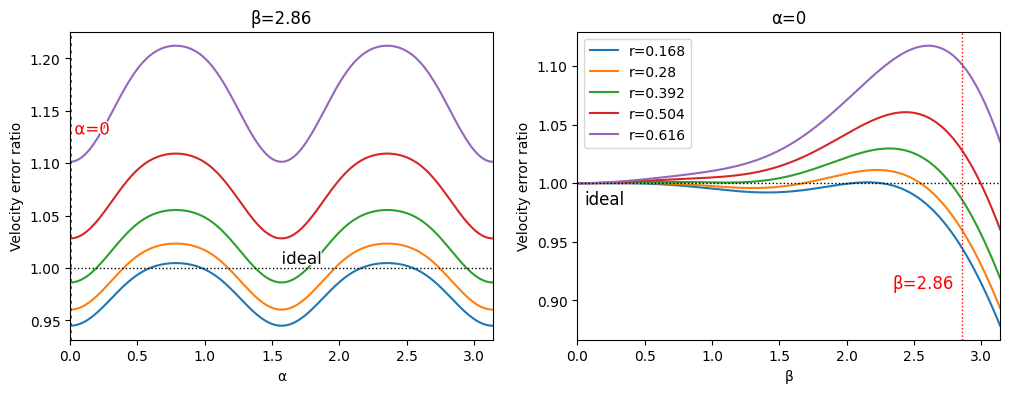

In [29]:
fig, ax = plt.subplots(1, 2)
dispersion_plot(drp_stencil2, h, dt, velocity=vrange, ax=ax)
fig.set_size_inches(12,4)
plt.show()

The optimisaion causes the dispersion to be worse at smaller velocities (Courant numbers) to improve the dispersion at higher velocities.

We can also see how closely the weights match the second derivative in Fourier space, which is how we optimised DRP stencil 1.

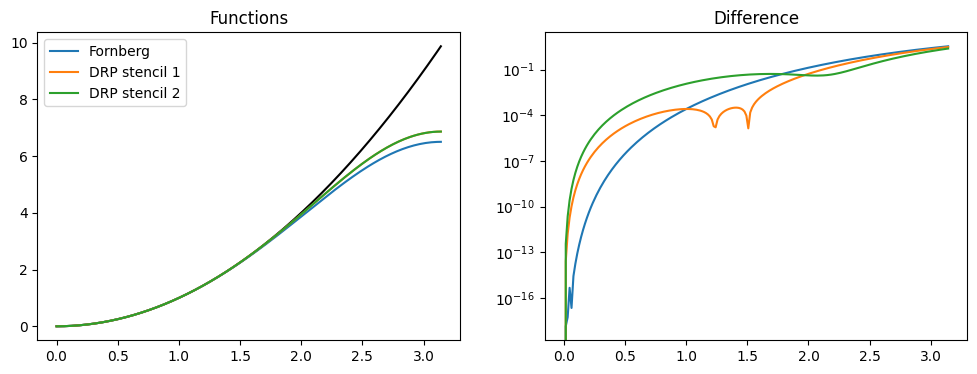

In [30]:
y_drp2 = - drp_stencil2[0] - 2*np.sum([a_ * np.cos(m_*x) for a_, m_ in zip(drp_stencil2[1:], m)], axis=0)

fig, ax = plt.subplots(1, 2)
ax[0].plot(x, x**2, 'k')
ax[0].plot(x, y_fornberg, label='Fornberg')
ax[0].plot(x, y_drp1, label='DRP stencil 1')
ax[0].plot(x, y_drp1, label='DRP stencil 2')
ax[0].legend()
ax[0].set_title('Functions')

ax[1].semilogy(x, np.abs(x**2 - y_fornberg))
ax[1].semilogy(x, np.abs(x**2 - y_drp1))
ax[1].semilogy(x, np.abs(x**2 - y_drp2))
ax[1].set_title('Difference')

fig.set_size_inches(12, 4)
plt.show()

The two DRP stencils produce curves that are indistinguishable in the left hand plot, the difference is only really noticable in the logarithmic difference, where we see larger error for DRP stencil 2 than DRP stencil 1, while still remaining small.

We can also look at the isosurfaces of the velocity difference function $\hat{\delta}$, the expression that the objective function tried to minimise.

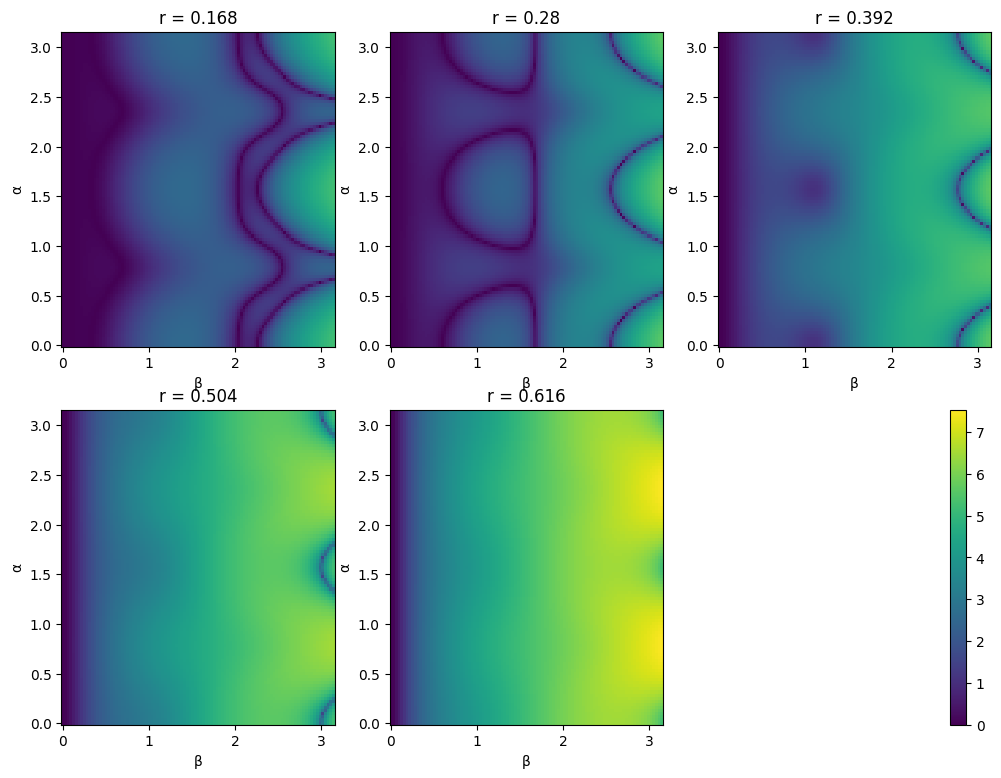

In [31]:
fig, ax = plt.subplots(2, 3)
cb = plot_levelset(drp_stencil2, alpha, k, vrange, ax, h, dt)
ax[-1][-1].set_visible(False)
fig.colorbar(cb, ax=ax[-1][-1])
fig.set_size_inches(12, 9)
plt.show()

Across all plotted velocities, the isosurface is darker than the above plots produced using the Fornberg stencil, corresponding to a smaller difference between the finite difference approximation to the velocity and the true velocity.

Finally, we simulate the acoustic wave equation using these coefficients, for different $\Delta t$, as we did before:

In [32]:
u , data , r = acoustic(weights=drp_stencil2, h=h, dt=dt, v=1500)
um, datam, rm = acoustic(weights=drp_stencil2, h=h, dt=dt/2, v=1500)
up, datap, rp = acoustic(weights=drp_stencil2, h=h, dt=2*dt, v=1500)

Operator `Kernel` ran in 0.02 s
Operator `Kernel` ran in 0.03 s
Operator `Kernel` ran in 0.01 s


Operator `Kernel` ran in 0.03 s


Operator `Kernel` ran in 0.01 s


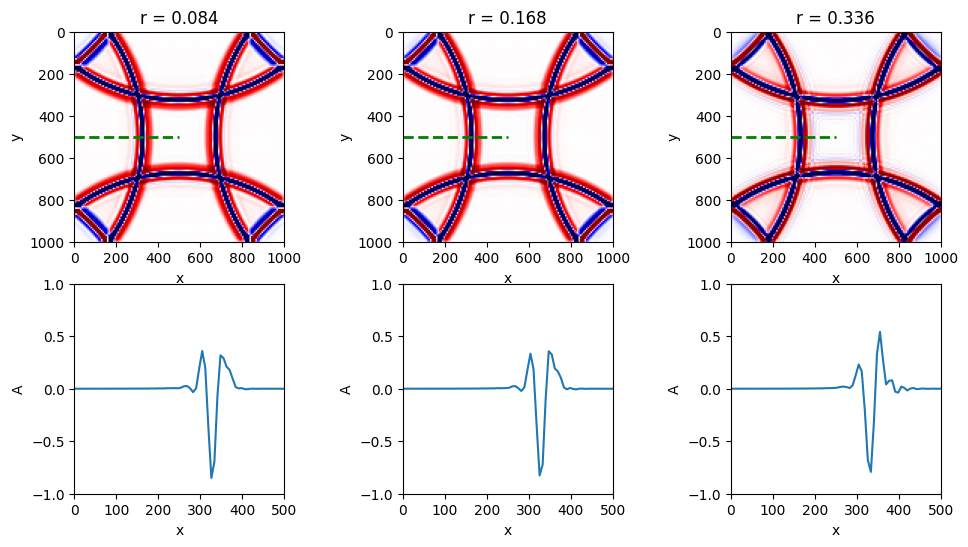

In [33]:
fig, ax = plt.subplots(2, 3)
plot_wave(um, ax[0, 0], hline=(0, 500, 500, 500), r=rm)
plot_wave( u, ax[0, 1], hline=(0, 500, 500, 500), r=r)
plot_wave(up, ax[0, 2], hline=(0, 500, 500, 500), r=rp)

shape = u.shape
plot_profile(um[shape[0]//2, :shape[1]//2], ax[1,0], extent=(0, 500))
plot_profile( u[shape[0]//2, :shape[1]//2], ax[1,1], extent=(0, 500))
plot_profile(up[shape[0]//2, :shape[1]//2], ax[1,2], extent=(0, 500))

fig.set_size_inches(12, 6)
plt.show()

Amazing, the ripples following the wavelet have almost entirely disappeared! The unstable $\Delta t$ still looks bad, but this is unavoidable and only included to continue to demonstrate why it is not viable to use an unstable value.

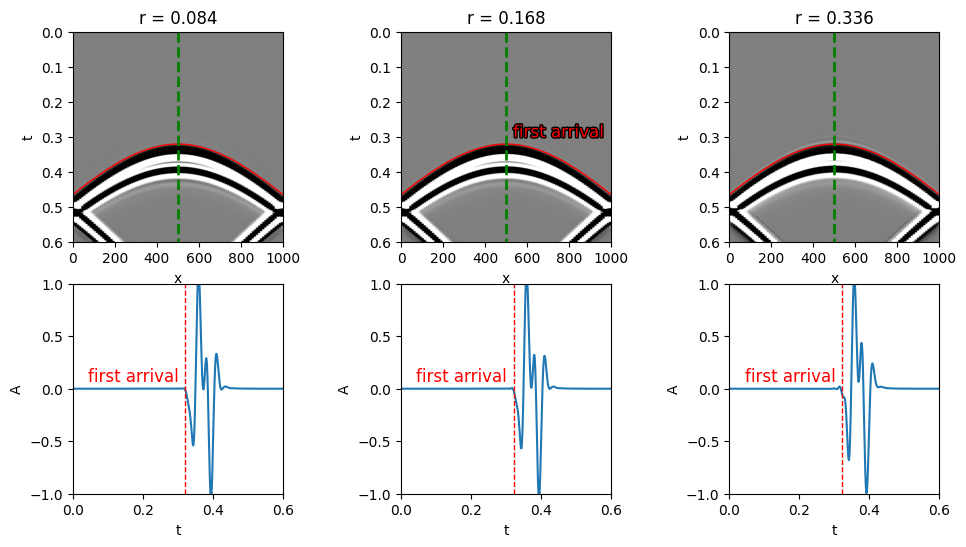

In [34]:
fig, ax = plt.subplots(2, 3)

arrival = plot_shot(data,  ax[0, 1], vline=(500, 0, 500, 0.6), r=r)
plot_shot(datam, ax[0, 0], vline=(500, 0, 500, 0.6), r=rm, first_arrival=arrival)
plot_shot(datap, ax[0, 2], vline=(500, 0, 500, 0.6), r=rp, first_arrival=arrival)

width = data.shape[1]
plot_profile(datam[:, width//2], ax[1, 0], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile( data[:, width//2], ax[1, 1], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])
plot_profile(datap[:, width//2], ax[1, 2], extent=(0, 0.6), axis_labels=('t', 'A'), first_arrival=arrival[width//2])

fig.set_size_inches(12, 6)
plt.show()

Again, the ripples following the wavelet have almost entirely disappeared. The unstable $\Delta t$ still has an incorrect first arrival wave, but this is expected.

## References
[1] **Generation of Finite Difference Formulas on Arbitrarily Spaced Grids** (1988)

_Bengt Fornberg_

Mathematics of Computation, Vol. 51, No. 184

http://dx.doi.org/10.1090/S0025-5718-1988-0935077-0, https://www.colorado.edu/amath/sites/default/files/attached-files/mathcomp_88_fd_formulas.pdf

[2] **Dispersion-Relation-Preserving Finite Difference Schemes for Computational Acoustics** (1993)

_Christopher K.W. Tam, Jay C. Webb_

Journal of Computational Physics, Volume 107, Issue 2, Pages 262-281, ISSN 0021-9991

https://doi.org/10.1006/jcph.1993.1142, https://www.sciencedirect.com/science/article/pii/S0021999183711423

[3] **Spatially-optimized finite-difference schemes for numerical dispersion suppression in seismic applications** (2019)

_Edward Caunt_

Masters Thesis

http://dx.doi.org/10.48550/arXiv.2107.13525, https://arxiv.org/pdf/2107.13525

[4] **A framework for automatically choosing the optimal parameters of finite-difference scheme in the acoustic wave modeling** (2022)

_Guiting Chen, Zhenming Peng, Yalin Li_

Computers & Geosciences, Volume 159, 104948, ISSN 0098-3004,

https://doi.org/10.1016/j.cageo.2021.104948, https://www.sciencedirect.com/science/article/pii/S009830042100234X